In [52]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [53]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [54]:
import os                      
import numpy as np              
import pandas as pd            
import torch                    
import matplotlib.pyplot as plt 
import torch.nn as nn           
from torch.utils.data import DataLoader 
from PIL import Image           
import torch.nn.functional as F 
import torchvision.transforms as transforms    
from torchvision.utils import make_grid       
from torchvision.datasets import ImageFolder  
from torchsummary import summary  

Displaying 3 images from class: Normal


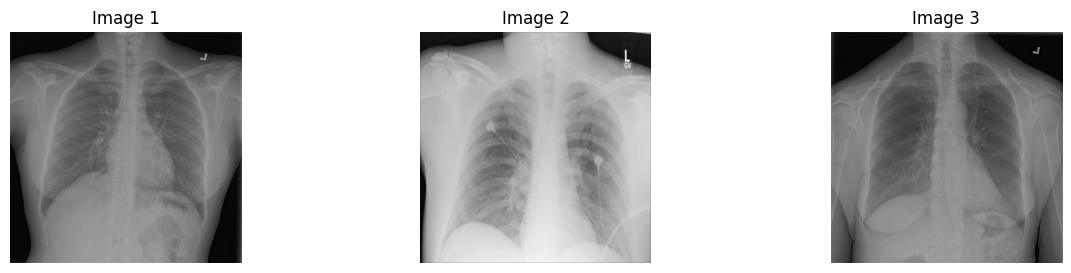

Displaying 3 images from class: Tuberculosis


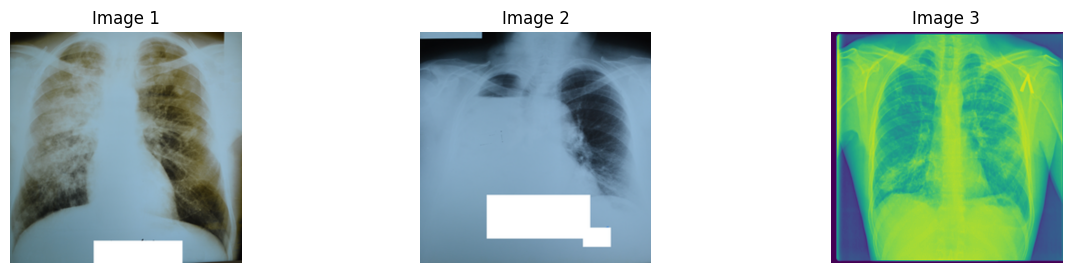

In [55]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

dataset_dir = r'/kaggle/input/tuberculosis2/orginal image'

classes = ["Normal","Tuberculosis"]


def display_images_per_class(dataset_dir, classes, num_images=3):
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        images = os.listdir(class_dir)
        images = random.sample(images, min(num_images, len(images)))
        print(f"Displaying {num_images} images from class: {class_name}")
        plt.figure(figsize=(15, 3))
        for i, image_name in enumerate(images):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1}")
            plt.axis('off')
        plt.show()

display_images_per_class(dataset_dir, classes, num_images=3)


In [56]:
dataset_diraug = r'/kaggle/input/tuberculosis2'

In [57]:
train_dir = dataset_diraug + "/augmented"
valid_dir = dataset_diraug + "/orginal image"
diseases = os.listdir(train_dir)

In [58]:
print(diseases)

['tuberculosis', 'normal']


In [59]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 2


In [60]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
tuberculosis,2800
normal,2796


              No. of Images
tuberculosis           2800
normal                 2796


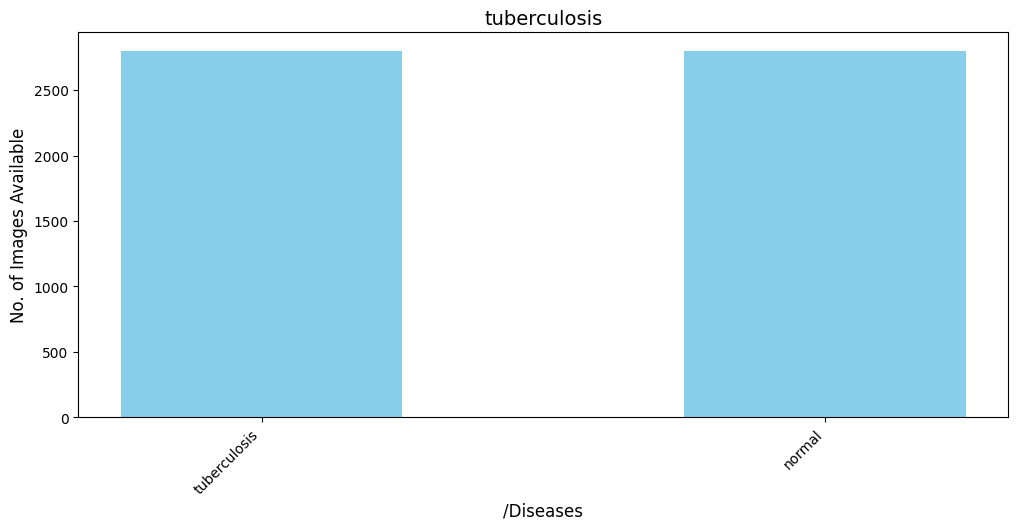

In [61]:
nums = {}
for disease in os.listdir(train_dir):  
    disease_path = os.path.join(train_dir, disease)
    if os.path.isdir(disease_path):  
        nums[disease] = len(os.listdir(disease_path))

# Convert the nums dictionary to a pandas DataFrame
img_per_class = pd.DataFrame(list(nums.values()), index=list(nums.keys()), columns=["No. of Images"])

# Display the DataFrame
print(img_per_class)


plt.figure(figsize=(12, 5))
plt.bar(img_per_class.index, img_per_class["No. of Images"], color='skyblue', width=0.5)

plt.xlabel('/Diseases', fontsize=12)
plt.ylabel('No. of Images Available', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('tuberculosis', fontsize=14)

plt.show()

In [62]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 5596 images for training


In [63]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [64]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 512, 512]) 0


In [65]:
len(train.classes)

2

In [66]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :normal(0)


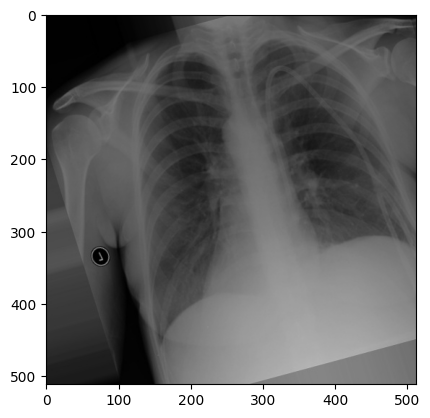

In [67]:
show_image(*train[0])

Label :normal(0)


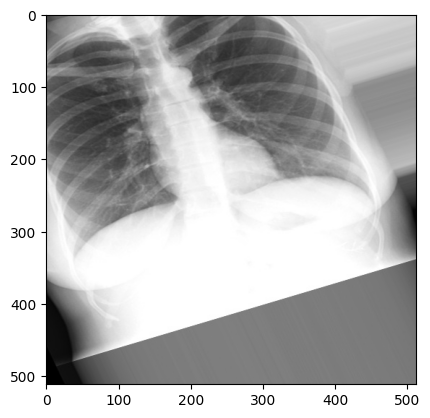

In [68]:
show_image(*train[1000])

Label :tuberculosis(1)


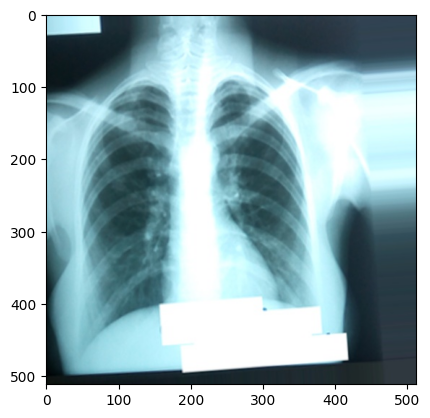

In [69]:
show_image(*train[3000])

In [70]:
random_seed = 7
torch.manual_seed(random_seed)

In [71]:
batch_size = 4

In [72]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [73]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

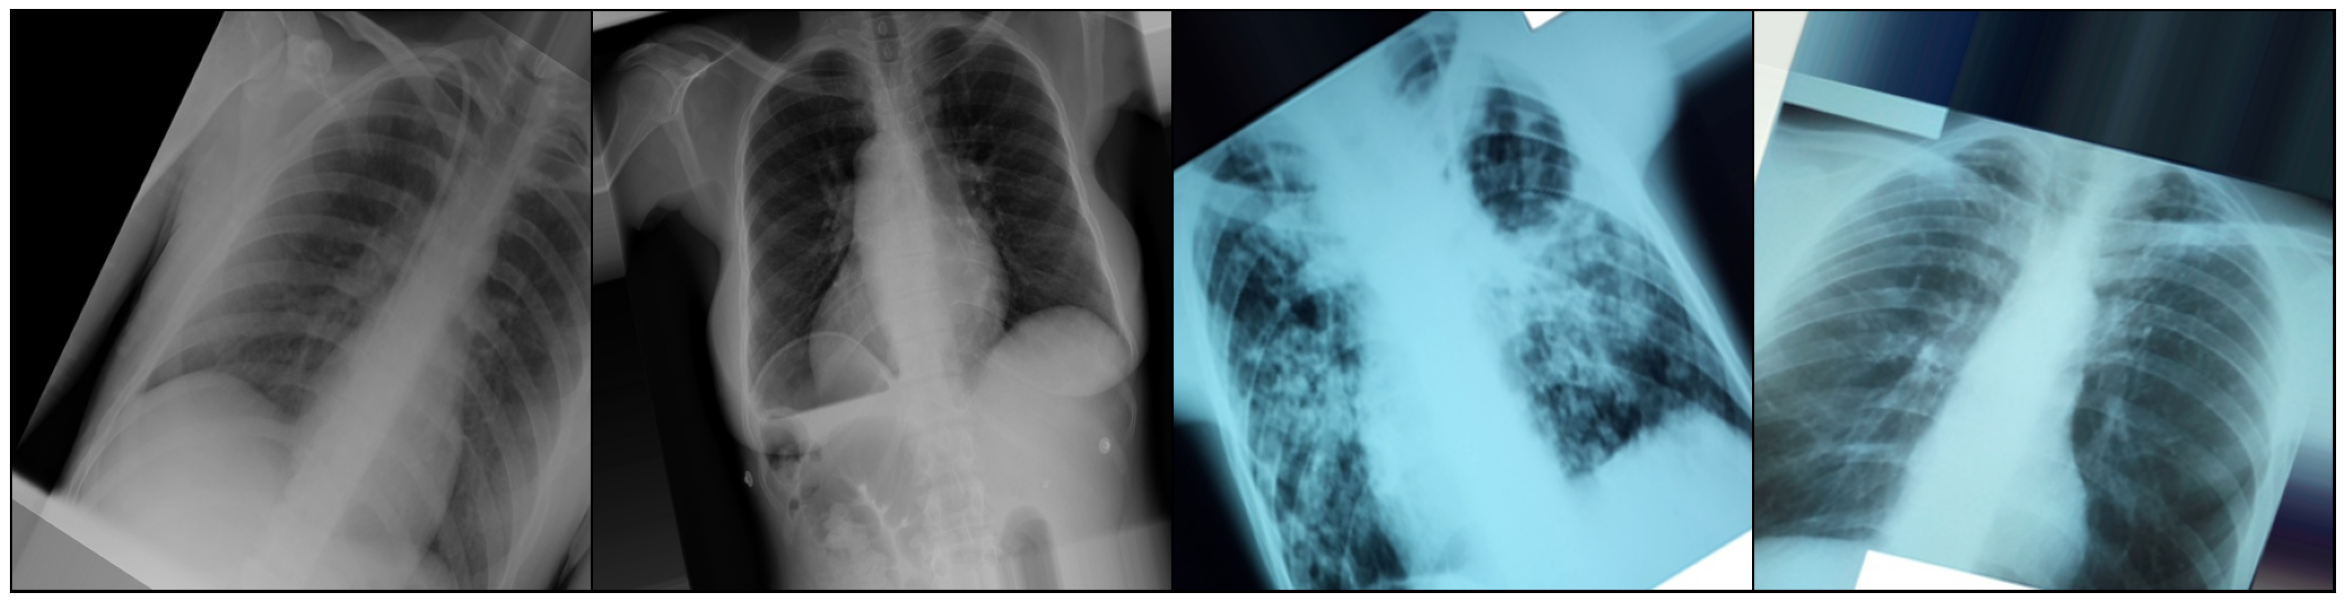

In [74]:
show_batch(train_dl) 

In [75]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [76]:
device = get_default_device()
device

device(type='cuda')

In [77]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [78]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [79]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [80]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.AdaptiveAvgPool2d(1))
    return nn.Sequential(*layers)


# resnet architecture 

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        print(out.shape)
        out = self.classifier(out)
        return out        

In [81]:
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AdaptiveAvgPool2d(output_size=1)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv3): Sequential(
    (

In [82]:
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

torch.Size([2, 512, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]         147,584
       BatchNorm2d-9            [-1, 128, 1, 1]             256
             ReLU-10            [-1, 128, 1, 1]               0
           Conv2d-11            [-1, 128, 1, 1]         147,584
      BatchNorm2d-12            [-1, 128, 1, 1]             256
             ReLU-13            [-1, 128, 1, 1]               0
           C

In [83]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [84]:
%%time
history = [evaluate(model, valid_dl)]
history

torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
t

[{'val_loss': tensor(0.6820, device='cuda:0'), 'val_accuracy': tensor(0.8333)}]

In [100]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [105]:
%%time

history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4,
                             opt_func=opt_func)

torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
t

In [107]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [108]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
torch.Size([4, 512, 1, 1])
t

In [109]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

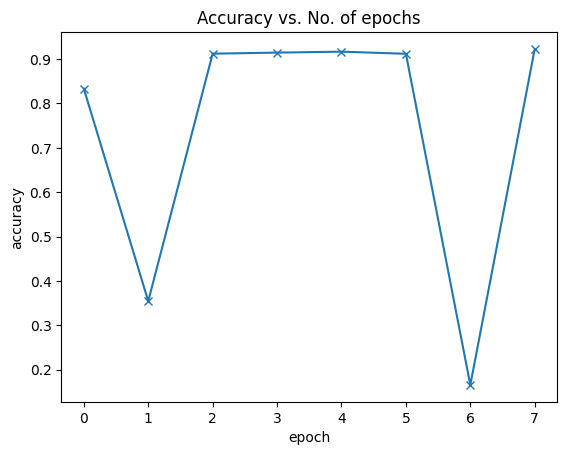

In [110]:
plot_accuracies(history)

In [111]:
import matplotlib.pyplot as plt

def plot_losses(history):
    train_losses = [x['train_loss'].cpu().detach().numpy() for x in history]
    val_losses = [x['val_loss'].cpu().detach().numpy() for x in history]
    
    plt.plot(train_losses, '-bx', label='Training Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

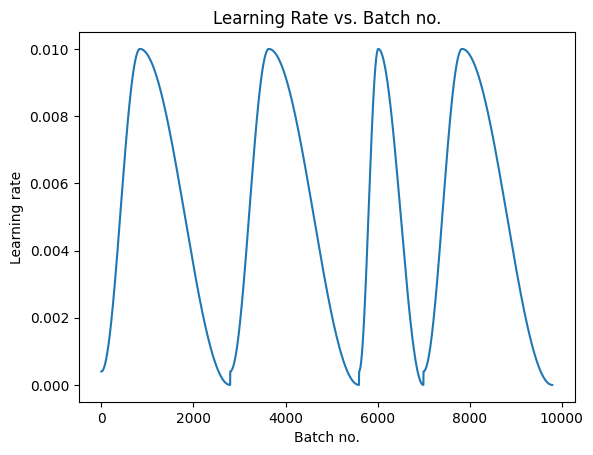

In [112]:
plot_lrs(history)

In [113]:
test_dir = "/kaggle/input/tuberculosis2"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [114]:
test_images = (os.listdir(test_dir + '/orginal image')) # since images in test folder are in alphabetical order
test_images

['Tuberculosis', 'Normal']

In [115]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

torch.Size([1, 512, 1, 1])
Label: Tuberculosis , Predicted: normal


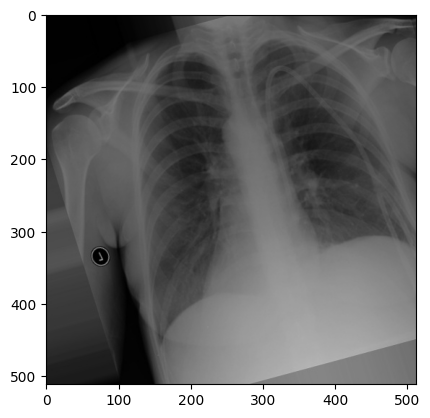

In [116]:
img, label = test[0]
plt.imshow(img.permute(1, 2,0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [118]:
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

torch.Size([1, 512, 1, 1])
Label: Tuberculosis , Predicted: normal
torch.Size([1, 512, 1, 1])
Label: Normal , Predicted: normal


IndexError: list index out of range

In [99]:
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

In [ ]:
# PATH = './plant-disease-model-complete.pth'
# torch.save(model, PATH)